<a href="https://colab.research.google.com/github/ASAB-001/ai_media_scheduler/blob/main/ai_media_scheduler_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

import schedule
import threading
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Media Schedule (Update with your own files)
media_schedule = [
    {"title": "Day 1", "type": "audio", "path": "/content/drive/MyDrive/MediaSchedulerApp/sample_audio1.mp3"},
    {"title": "Day 2", "type": "video", "path": "/content/drive/MyDrive/MediaSchedulerApp/sample_video.mp4"},
    {"title": "Day 3", "type": "pdf", "path": "/content/drive/MyDrive/MediaSchedulerApp/sample_document.pdf"},
    {"title": "Day 4", "type": "audio", "path": "/content/drive/MyDrive/MediaSchedulerApp/sample_audio2.mp3"},
    {"title": "Day 5", "type": "pdf", "path": "/content/drive/MyDrive/MediaSchedulerApp/sample_audio3.mp3"},
]

# Media Log
media_log = []

# Simulate media play
def simulate_play(file):
    print(f"Playing: {file['path']} ({file['type']})")

# Simulated PDF summarizer
def summarize_pdf(file_path):
    return "📄 Simulated AI Summary for PDF."

# Get next media to play
def get_next_media():
    index = len(media_log) % len(media_schedule)
    return media_schedule[index]

# Log media activity
def log_play(file):
    media_log.append({
        "title": file["title"],
        "type": file["type"],
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "result": "Played"
    })

# Main playback function
def play_media():
    file = get_next_media()
    simulate_play(file)
    log_play(file)
    if file["type"] == "pdf":
        print(summarize_pdf(file["path"]))

# Scheduler runner
def run_schedule():
    while True:
        schedule.run_pending()
        time.sleep(1)

# Schedule for demo (every 1 minute)
schedule.every(1).minutes.do(play_media)

# Start scheduler in background
threading.Thread(target=run_schedule, daemon=True).start()
print("Scheduler started (1-minute demo loop)")

# Show activity log
def show_log():
    df = pd.DataFrame(media_log)
    display(df)
    return df

# Show dashboard chart
def show_dashboard():
    df = pd.DataFrame(media_log)
    if df.empty:
        print("No data yet.")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x='date', hue='type')
    plt.title("Media Summary by Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\nSummary Stats:\n- Total sessions: {len(df)}")
    print(f"- Unique days: {df['date'].nunique()}")
    print(f"- Media breakdown:\n{df['type'].value_counts()}")

# Export to CSV
def export_usage():
    df = pd.DataFrame(media_log)
    df.to_csv("/content/drive/MyDrive/MediaSchedulerApp/media_usage_log.csv", index=False)
    print("Usage log exported.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Scheduler started (1-minute demo loop)


,title,type,timestamp,result
0,Day 1,audio,2025-06-20 00:38:17,Played
1,Day 2,video,2025-06-20 00:38:58,Played
2,Day 3,pdf,2025-06-20 00:39:10,Played
3,Day 4,audio,2025-06-20 00:39:17,Played


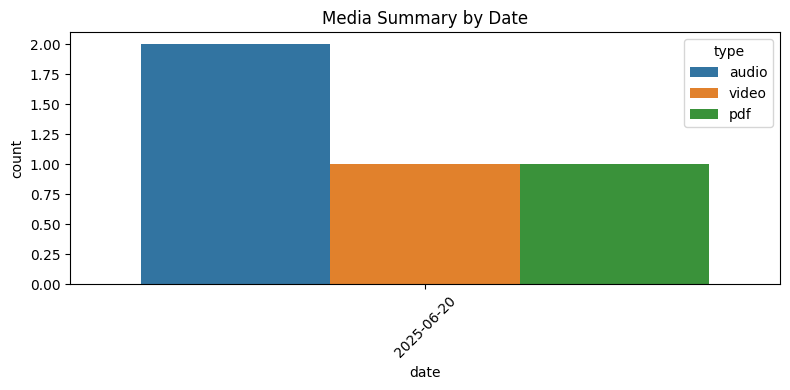


Summary Stats:
- Total sessions: 4
- Unique days: 1
- Media breakdown:
type
audio    2
video    1
pdf      1
Name: count, dtype: int64
✅ Usage log exported.


In [26]:

# View current play log
show_log()
# Show charts and summary
show_dashboard()
# Export to your Google Drive
export_usage()